# Machine Learning

Through our heatmap we saw that there is correlation in terms of closing price between different cryptocurrencies.

The question now is, can we get a machine learning in order to recognize those relationship?

As we saw group of companies are likely to move together either up or down but not necesserily at the same time.
Most of the times people try to get a price prediction based on the history of that only cryptocurrency.
In our case being this previous approach almost always useless we will try to get a prediction using numerous cryptocurrencies to see if we can get a real edge.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import itertools
import operator
from matplotlib import style
from sklearn import svm, preprocessing
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

### Preprocess data for Machine Learning

First thing we create a function that's gonna define the number of hours we want in the future in order to get a hold, buy or sell label.

Doing so we are creating in our case 3 extra columns that are gonna be our lagged prices in the future.

In [2]:
def process_data_for_labels(symbol):
    '''Create n columns containing the values of the price difference normalized
       based on the hours we want to predict in future
    
       Args:
           symbol: cryptocurrency timeseries we want to predict
           
       Returns:
           hours: hours in the future we want to predict
           symbols: cryptocurrency timeseries we want to predict
           df: df containing 500 cryptocurrencies with new columns
    '''
    hours = 3
    df = pd.read_csv('500crypto_joined_close.csv', index_col=0)
    symbols = df.columns.values.tolist()
    
    for i in range(1, hours+1):
        df[f'{symbol}_{i}h'] = (df[symbol].shift(-i) - df[symbol]) / df[symbol]
        
    df.fillna(0, inplace=True)
    
    return hours, symbols, df

In [3]:
process_data_for_labels('ETHBTC')

(3,
 ['ETHBTC',
  'LTCBTC',
  'BNBBTC',
  'NEOBTC',
  'QTUMETH',
  'EOSETH',
  'SNTETH',
  'BNTETH',
  'GASBTC',
  'BNBETH',
  'BTCUSDT',
  'ETHUSDT',
  'OAXETH',
  'DNTETH',
  'MCOETH',
  'MCOBTC',
  'WTCBTC',
  'WTCETH',
  'LRCBTC',
  'LRCETH',
  'QTUMBTC',
  'YOYOBTC',
  'OMGBTC',
  'OMGETH',
  'ZRXBTC',
  'ZRXETH',
  'STRATBTC',
  'STRATETH',
  'SNGLSBTC',
  'BQXBTC',
  'BQXETH',
  'KNCBTC',
  'KNCETH',
  'FUNBTC',
  'FUNETH',
  'SNMBTC',
  'NEOETH',
  'IOTABTC',
  'IOTAETH',
  'LINKBTC',
  'LINKETH',
  'XVGBTC',
  'XVGETH',
  'MDABTC',
  'MDAETH',
  'MTLBTC',
  'MTLETH',
  'EOSBTC',
  'SNTBTC',
  'ETCETH',
  'ETCBTC',
  'MTHBTC',
  'MTHETH',
  'ENGBTC',
  'ENGETH',
  'DNTBTC',
  'ZECBTC',
  'ZECETH',
  'BNTBTC',
  'ASTBTC',
  'ASTETH',
  'DASHBTC',
  'DASHETH',
  'OAXBTC',
  'BTGBTC',
  'EVXBTC',
  'EVXETH',
  'REQBTC',
  'REQETH',
  'VIBBTC',
  'VIBETH',
  'TRXBTC',
  'TRXETH',
  'POWRBTC',
  'POWRETH',
  'ARKBTC',
  'ARKETH',
  'XRPBTC',
  'XRPETH',
  'ENJBTC',
  'ENJETH',
  'ST

# Create labels buy, hold, sell for machine learning

Create buy, hold, sell labels based on a % change.

In [4]:
def buy_sell_hold(*args):
    '''Return 1, 0, -1 based on % change
    
       Args:
           *args: pass any number of parameters
    '''
    cols = [c for c in args]
    change_perc = 0.03
    for col in cols:
        if col > change_perc:
            return 1
        if col < -change_perc:
            return -1
    return 0

In [5]:
def extract_feature_sets(symbol):
    '''Create feature sets y and X
    
       Args:
           symbol: cryptocurrency timeseries we want to predict
           
       Returns:
           X: Percentage change in data fo all of the cryptocurrencies including company in question
           y: labels 1, 0, -1
           df: df containing 500 cryptocurrencies with new columns
    '''
    
    hours, symbols, df = process_data_for_labels(symbol)
    
    df[f'{symbol}_target'] = list(map(buy_sell_hold, *[df[f'{symbol}_{i}h'] for i in range(1, hours+1)]))
    
    labels = df[f'{symbol}_target'].values.tolist()
    str_labels = [str(i) for i in labels]
    print('Data Spread: ', Counter(str_labels))
    
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    # Create Feature Sets
    # Percentage change in data for all of the cryptocurrencies including company in question
    df_vals = df[[symbol for symbol in symbols]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    #df_vals.drop(df_vals.columns[[-2, -3, -4]], axis = 1, inplace = True) 
    
    X = df_vals.values
    y = labels
    
    return X, y, df_vals

In [8]:
X, y, df_vals = extract_feature_sets('BTCUSDT')

Data Spread:  Counter({'0': 2448, '-1': 28, '1': 20})


In [14]:
def conf_matrix(y_test, y_pred):
    ''' Plot confusion matrix
    
        Args: 
            X: model features (df)
            y: model target feature (df)
            cw: weight class parameter classifier = balanced
            avg: f1 metric
            
        Returns: 
            clf: fitted instance of LogReg classifier
            y_pred: prediction made on X_test data (np array)
            train_score_logreg: score for Train data (float)
            test_score_logreg: score for Test data (float)
    '''
    
    labels = [-1, 0, 1]
    cnf_matrix = confusion_matrix(y_test, y_pred, labels)
    
    plt.figure(figsize = (12,8))
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues, aspect='auto') #Create the basic matrix.
    
    #Add title and Axis Labels
    plt.title('Confusion Matrix', fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    
    #Add appropriate Axis Scales
    class_names = set(y) #Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, fontsize=20)
    plt.yticks(tick_marks, class_names, fontsize=20)
    
    #Add Labels to Each Cell
    thresh = cnf_matrix.max() / 2. #Used for text coloring below
    #Here we iterate through the confusion matrix and append labels to our visualization.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment="center",
                     fontsize =18,
                     color="white" if cnf_matrix[i, j] > thresh else "black")
    
    #Add a Side Bar Legend Showing Colors
    plt.colorbar();

In [15]:
 def log_regr(X, y ,cw='balanced', avg='macro'):
    ''' train LogRegr Classifier and calculate score on Train and Test data
    
        Args: 
            X: model features (df)
            y: model target feature (df)
            cw: weight class parameter classifier = balanced
            avg: f1 metric
            
        Returns: 
            clf: fitted instance of LogReg classifier
            y_pred: prediction made on X_test data (np array)
            train_score_logreg: score for Train data (float)
            test_score_logreg: score for Test data (float)
    '''
    # Train a LogRegr classifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
    clf = LogisticRegression(random_state=10, class_weight=cw)
                             
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calculate f1 score
    
    log_regr_f1_score = f1_score(y_test, y_pred, average=avg)
    
    # Calculate Score
    train_score_logreg = clf.score(X_train, y_train)
    test_score_logreg = clf.score(X_test, y_test)
    print("LogReg Train score: ", train_score_logreg)
    print("LogReg Test score: ", test_score_logreg)
    print(f"LogReg f1 Score: {log_regr_f1_score}")
    print("\n")
    
    return clf, train_score_logreg, test_score_logreg

In [16]:
 def dec_tree(X, y, cw='balanced', avg='macro'):
    ''' train DecTree Classifier using GridSearch and calculate score on Train and Test data
    
        Args: 
            X: model features (df)
            y: model target feature (df)
            cw: weight class parameter classifier = balance
            avg: f1 metric
            
        Returns: 
            clf_dec_tree: fitted instance of DecisionTree classifier
            dt_grid_search: fitted instance of GridSearch classifier
            dt_gs_train_score: score for Train data (float)
            dt_gs_testing_score: score for Test data (float)
    '''
    # Train a DT classifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    clf_dec_tree = DecisionTreeClassifier(random_state=10, class_weight=cw)  
    clf_dec_tree.fit(X_train, y_train)  
    
    # GridSearch
    dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
    }
    
    # Instantiate GridSearchCV
    dt_grid_search = GridSearchCV(clf_dec_tree, dt_param_grid, cv=3, return_train_score=True)
    dt_grid_search.fit(X_train, y_train)
    y_pred = dt_grid_search.predict(X_test)
    
    # Calculate f1 score
    
    dt_gs_f1_score = f1_score(y_test, y_pred, average=avg)
    
    # Calculate Score
    dt_gs_train_score = dt_grid_search.score(X_train, y_train)
    dt_gs_testing_score = dt_grid_search.score(X_test, y_test)
    print("DecTree GridSearch Train score: ", dt_gs_train_score)
    print("DecTree GridSearch Test score: ", dt_gs_testing_score)
    print(f"Optimal Parameters: {dt_grid_search.best_params_}")
    print(f"DecTree f1 Score: {dt_gs_f1_score}" )
    print("\n")
    
    
    return clf_dec_tree, dt_grid_search, dt_gs_train_score, dt_gs_testing_score, y_test, y_pred

In [17]:
 def rand_for(X, y, cw='balanced', avg='macro'):
    ''' train RandFor Classifier using GridSearch, calculate score on Train and Test data and 
        Visualize feature importance
    
        Args: 
            X: model features (df)
            y: model target feature (df)
            cw: weight class parameter classifier = balanced
            avg: f1 metric
            
        Returns: 
            rf_grid_search: fitted instance of GridSearch classifier
            rf_gs_train_score: score for Train data (float)
            rf_gs_testing_score: score for Test data (float)
            rf_gs_f1_score: f1 score
    '''
    # Train a RF classifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    clf_rand_for = RandomForestClassifier(random_state=10, class_weight=cw)  
    clf_rand_for.fit(X_train, y_train)  
    
    # GridSearch
    rf_param_grid = {
    'n_estimators': [10, 30],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 3, 6]
    }
    
    # Instantiate GridSearchCV
    rf_grid_search = GridSearchCV(clf_rand_for, rf_param_grid, cv=3)
    rf_grid_search.fit(X_train, y_train)
    
    # Calculate Score
    rf_gs_train_score = rf_grid_search.score(X_train, y_train)
    rf_gs_testing_score = rf_grid_search.score(X_test, y_test)
    y_pred_gs = rf_grid_search.predict(X_test)
    
    # Calculate f1 score
    
    rf_gs_f1_score = f1_score(y_test, y_pred_gs, average=avg)
    
    # Sort feature_importances in a graph
    emp_dict = {}
    for f, i in zip(df.columns, clf_rand_for[0].feature_importances_):
        emp_dict[f] = i
    sorted_feat_import = list( sorted(emp_dict.items(), key=operator.itemgetter(1),reverse=True))
    
    # Visualize feature_importances in a graph
    plt.figure(figsize=(12,8))
    plt.barh([x[0] for x in sorted_feat_import[:30]], [x[1] for x in sorted_feat_import[:30]])
    plt.title('Top 30 Feature Importances', fontsize=22)
    plt.xlabel('Feature Weight', fontsize=20)
    plt.ylabel('Feature', fontsize=20)
    plt.gca().invert_yaxis()
    plt.show();
    
    print("RandFor GridSearch Train score: ", rf_gs_train_score)
    print("RandFor GridSearch Test score: ", rf_gs_testing_score)
    print(f"RandFore GridSearch f1 Score: {rf_gs_f1_score}")
    print(f"Optimal Parameters: {rf_grid_search.best_params_}")
    print("\n")
    
    return  clf_rand_for, rf_grid_search, rf_gs_train_score, rf_gs_testing_score

# Do machine learning tweaking several parameters

### ML class_weight = 'balanced' & f1 metric = 'macro'

In [18]:
def machine_learning(X, y, cw='balanced', avg='macro'):
    ''' runs log_regr, dec_tree and rand_for functions
    
        print Confusion Matrices for Logistic Regression and Random Forest
    
        Args: 
            X: model features (df)
            y: model target feature (df)
        
    '''    
    clf, train_score_logreg, test_score_logreg = log_regr(X, y, cw='balanced', avg='micro')
    clf_dec_tree, dt_grid_search, dt_gs_train_score, dt_gs_testing_score, y_test, y_pred = dec_tree(X, y, cw='balanced', avg='micro')
    clf_rand_for, rf_grid_search, rf_gs_train_score, rf_gs_testing_score= rand_for(X, y, cw='balanced', avg='micro')
    
    #Create and print a confusion matrix 
    conf_matrix(y_test, y_pred);

LogReg Train score:  0.9807692307692307
LogReg Test score:  0.9807692307692307
LogReg f1 Score: 0.9807692307692307


DecTree GridSearch Train score:  1.0
DecTree GridSearch Test score:  0.9487179487179487
Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecTree f1 Score: 0.9487179487179487




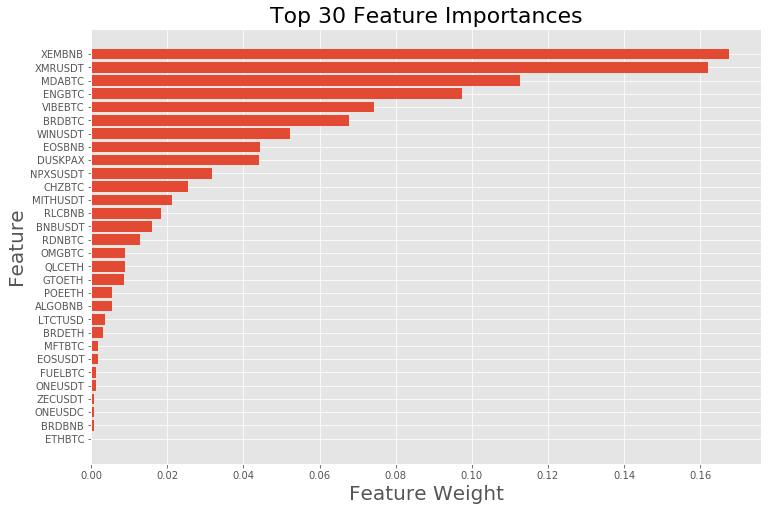

RandFor GridSearch Train score:  0.9957264957264957
RandFor GridSearch Test score:  0.9791666666666666
RandFore GridSearch f1 Score: 0.9791666666666666
Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}




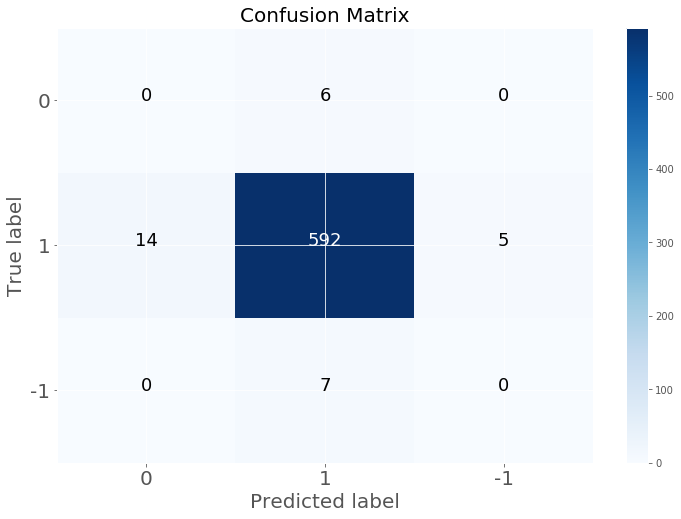

In [19]:
machine_learning(X, y, cw=None, avg=None)

### ML class_weight = 'balanced' & f1 metric = 'None'

LogReg Train score:  0.9807692307692307
LogReg Test score:  0.9807692307692307
LogReg f1 Score: 0.9807692307692307


DecTree GridSearch Train score:  1.0
DecTree GridSearch Test score:  0.9487179487179487
Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecTree f1 Score: 0.9487179487179487




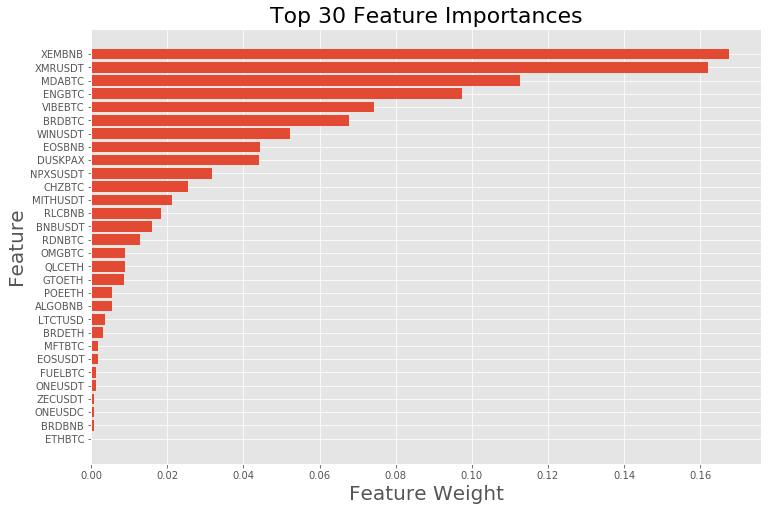

RandFor GridSearch Train score:  0.9957264957264957
RandFor GridSearch Test score:  0.9791666666666666
RandFore GridSearch f1 Score: 0.9791666666666666
Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}




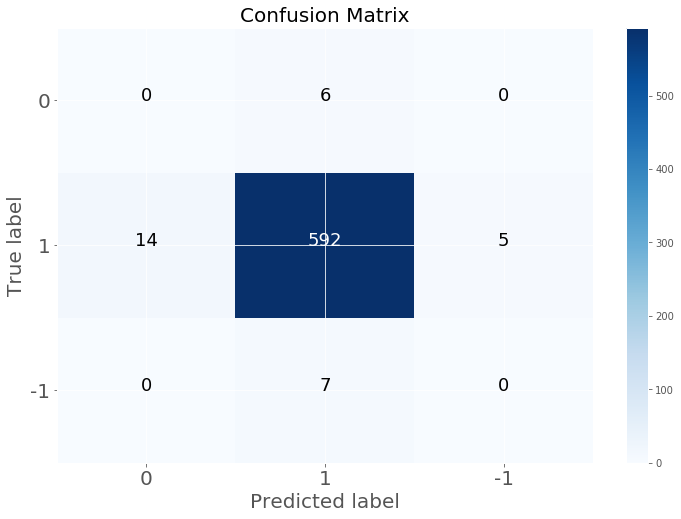

In [20]:
machine_learning(X, y, cw='balanced', avg=None)

### ML class_weight = 'balanced' & f1 metric = 'micro'

LogReg Train score:  0.9807692307692307
LogReg Test score:  0.9807692307692307
LogReg f1 Score: 0.9807692307692307


DecTree GridSearch Train score:  1.0
DecTree GridSearch Test score:  0.9487179487179487
Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecTree f1 Score: 0.9487179487179487




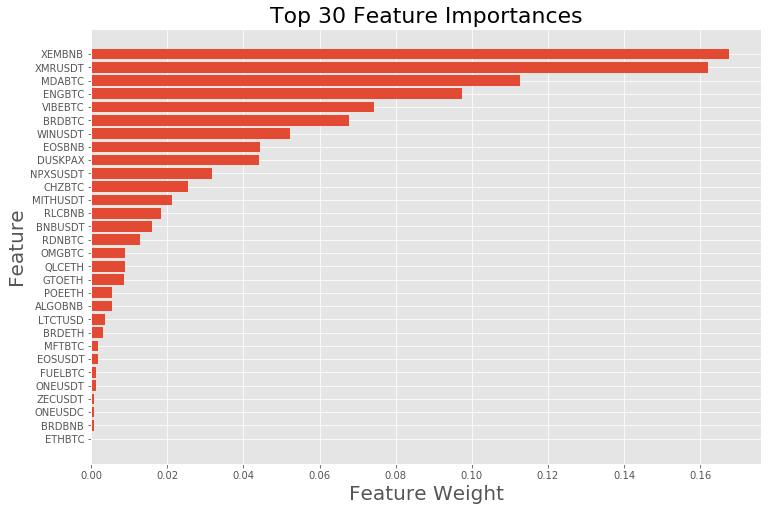

RandFor GridSearch Train score:  0.9957264957264957
RandFor GridSearch Test score:  0.9791666666666666
RandFore GridSearch f1 Score: 0.9791666666666666
Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}




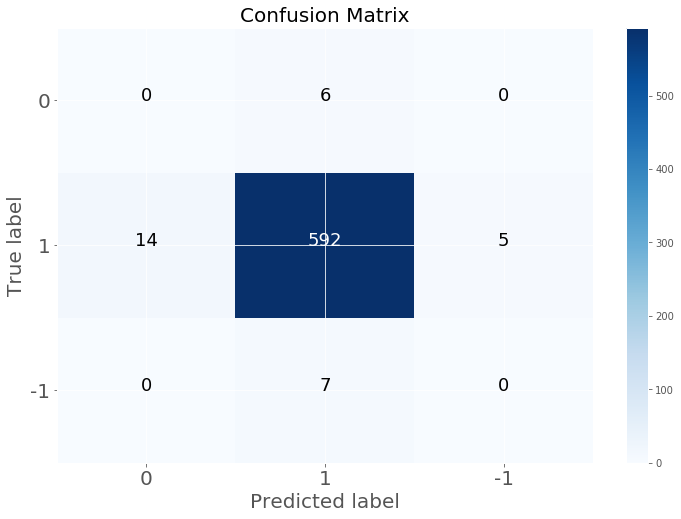

In [21]:
machine_learning(X, y, cw='balanced', avg='micro')

# Results

As we saw from our machine learning models also if we tweak our parameter we always obtain a really high accuracy and f1 score.

Also if this might seem a pretty good result we need to consider that all the models are clearly overfitting due to the imbalanced classes.

In the next step I am going to balance our classes manually tweaking the % change in prices and see if we can obtain a more realistic result.

It is worthed to mention that in order to balance our classes in this way we need to lower the % change in price.
In this case only a trading bot will be able to apply this strategy.

In [22]:
def buy_sell_hold(*args):
    '''Return 1, 0, -1 based on % change
    
       Args:
           *args: pass any number of parameters
    '''
    cols = [c for c in args]
    change_perc = 0.005
    for col in cols:
        if col > change_perc:
            return 1
        if col < -change_perc:
            return -1
    return 0

In [23]:
X, y, df = extract_feature_sets('ETHUSDT')

Data Spread:  Counter({'0': 898, '1': 804, '-1': 794})


In [24]:
df.columns

Index(['ETHBTC', 'LTCBTC', 'BNBBTC', 'NEOBTC', 'QTUMETH', 'EOSETH', 'SNTETH',
       'BNTETH', 'GASBTC', 'BNBETH',
       ...
       'BUSDUSDT', 'BEAMBNB', 'BEAMBTC', 'BEAMUSDT', 'XTZBNB', 'XTZBTC',
       'XTZUSDT', 'RENUSDT', 'RVNUSDT', 'HCUSDT'],
      dtype='object', length=500)

LogReg Train score:  0.49893162393162394
LogReg Test score:  0.34615384615384615
LogReg f1 Score: 0.34615384615384615


DecTree GridSearch Train score:  0.6014957264957265
DecTree GridSearch Test score:  0.38782051282051283
Optimal Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecTree f1 Score: 0.38782051282051283




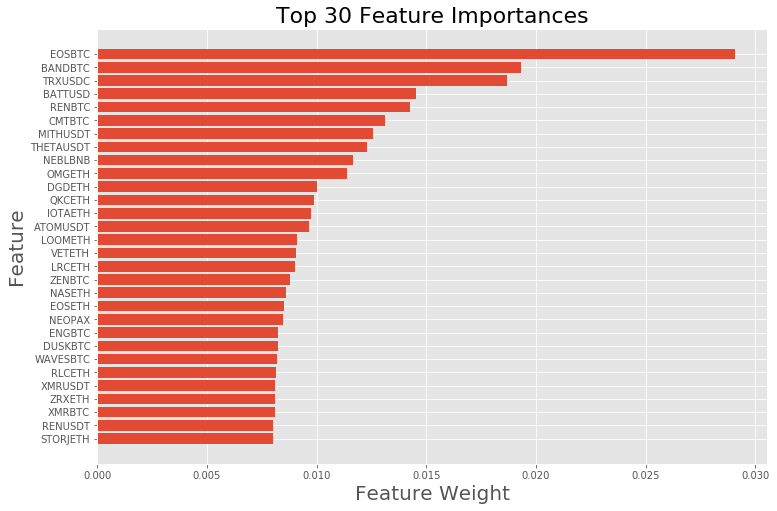

RandFor GridSearch Train score:  0.8402777777777778
RandFor GridSearch Test score:  0.47435897435897434
RandFore GridSearch f1 Score: 0.47435897435897434
Optimal Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 30}




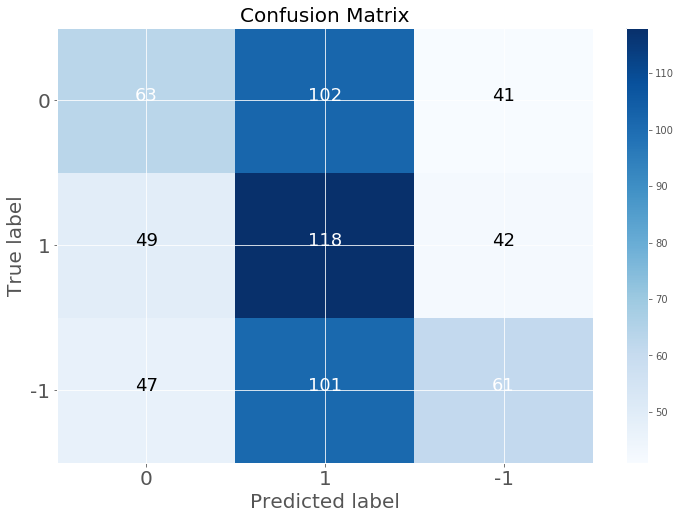

In [25]:
machine_learning(X, y, cw=None, avg='macro')

# Final results

As we can see logistic regression is able to have a little edge over the 33% that we would expect from random guessing but just of 2%.

Tweaking a bit the model makes us doing slighly better.

We do need moreover to take in consideration that if our model is also capable of doing 7/8% better the risk of losing everything when the model is not performing well is really high.